In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import set_config

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X, y = fetch_openml(
    "titanic", version=1, as_frame=True, return_X_y=True, parser="pandas"
)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
X_train.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
813,3,"Franklin, Mr. Charles (Charles Fardon)",male,NaN,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S,NaN,NaN,NaN
809,3,"Ford, Mr. Edward Watson",male,18.0,2,2,W./C. 6608,34.3750,NaN,S,NaN,NaN,"Rotherfield, Sussex, England Essex Co, MA"
906,3,"Jonsson, Mr. Nils Hilding",male,27.0,0,0,350408,7.8542,NaN,S,NaN,NaN,NaN
305,1,"Weir, Col. John",male,60.0,0,0,113800,26.5500,NaN,S,NaN,NaN,"England Salt Lake City, Utah"
988,3,"Mahon, Mr. John",male,NaN,0,0,AQ/4 3130,7.7500,NaN,Q,NaN,NaN,NaN


In [4]:
num_features = ['age', 'fare']
cat_features = ['embarked', 'sex', 'pclass']

In [5]:
# here we call the new API set_config to tell sklearn we want to output a pandas DF
set_config(transform_output="pandas")

# creating the numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

#creating the transform to preprocess de data
transformer = ColumnTransformer(
    (
        ('numerical', num_pipe, num_features),
        ("categorical", 
             OneHotEncoder(sparse_output=False, 
                           drop="if_binary", 
                           handle_unknown="ignore"), 
             cat_features
        )
    ),
    verbose_feature_names_out=False,
)

In [6]:
# creating the classifier pipeline with a data preprocessing step and RF classifier
rf_pipeline = Pipeline([
    ('dataprep', transformer),
    ('rf_clf', RandomForestClassifier(n_estimators=100, 
                                      max_depth=10, 
                                      class_weight='balanced', 
                                      random_state=123, 
                                      verbose=0))
])

In [7]:
# training the model
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('dataprep',
                 ColumnTransformer(transformers=(('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['embarked', 'sex',
                                                   'pclass'])),
                                   verbose_feature_names_out=False)),
                ('rf_clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        random_state=123))])

In [8]:
# predicting on test dataset
y_pred = rf_pipeline.predict(X_test)

C:\Users\ander\Documents\Estudos ML\scikit-learn\sklearn\preprocessing\_encoders.py:189: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [9]:
# model performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       203
           1       0.80      0.69      0.74       125

    accuracy                           0.82       328
   macro avg       0.81      0.79      0.80       328
weighted avg       0.82      0.82      0.81       328



In [10]:
# retrieving the RF Classifier from the model pipeline
clf = rf_pipeline[-1]

In [11]:
# as we can see here, now we can keep the feature names inputted to our classifier
# even though we are using the Pipeline class

print(clf.feature_names_in_)
print(clf.feature_importances_)

['age' 'fare' 'embarked_C' 'embarked_Q' 'embarked_S' 'sex_male' 'pclass_1'
 'pclass_2' 'pclass_3']
[0.27531006 0.27718031 0.016265   0.00940305 0.01344312 0.29538258
 0.04037679 0.01732475 0.05531434]


In [12]:
# making a pandas dataframe
data = list(zip(clf.feature_names_in_, clf.feature_importances_))
df_importances = pd.DataFrame(data, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
df_importances

,Feature,Importance
5,sex_male,0.295383
1,fare,0.277180
0,age,0.275310
8,pclass_3,0.055314
6,pclass_1,0.040377
7,pclass_2,0.017325
2,embarked_C,0.016265
4,embarked_S,0.013443
3,embarked_Q,0.009403


<AxesSubplot: ylabel='Feature'>

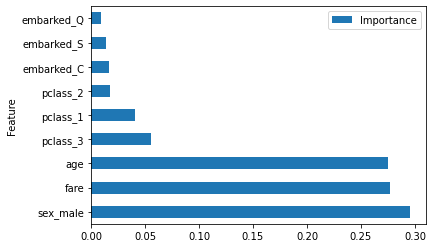

In [13]:
df_importances.plot.barh(x='Feature', y='Importance')